# Spectrogram Generation for Call Classification Model Training

### This notebook generates spectrograms in PyTorch (.pt) format from audio files to train the beluga call classification model.

We used to have dataset using 3s snippets, but then moved to 1s and labeled all the overlaps, as we move forward we should clean up how we handle the data, to have cleaner code.



In [8]:
from dotenv import load_dotenv
from pathlib import Path
import sys
import os

# Walk up until we find the project root (folder with the .env)
current_path = Path().resolve()
for parent in [current_path] + list(current_path.parents):
    if (parent / ".env").exists():
        load_dotenv(parent / ".env")
        project_root = os.getenv("PROJECT_ROOT")
        print(project_root)
        sys.path.append(project_root)     
        break


%load_ext autoreload
%autoreload 2

/Users/emmanuel/Documents/belugas/beluga-call-pipeline
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:

import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import librosa
from data_preprocessing.spectrogram.spectrogram_generator import HYDROPHONE_SENSITIVITY, SpectrogramGenerator
import pandas as pd
import torch

from tqdm import tqdm
import os


In [ ]:
#Loading the labels for the overlaps
overlaps_df = pd.read_csv("../data/labels/Overlaps_1s.csv")


In [11]:
spect_generator = SpectrogramGenerator(
        n_fft=2048,
        hop_length=int(2048/2),
        n_mels=64,
        fmin=200,
        sample_rate=192000, 
    )

In [ ]:

DATA_DIRECTORY = "../data/"

wavs_folder_path_3s = DATA_DIRECTORY + "Full_Dataset/Snippets_3s_wav/"
wavs_folder_path_1s = DATA_DIRECTORY + "Full_Dataset/New_Absences_1s/"

output_dir = DATA_DIRECTORY + "Full_Dataset/Overlaps_1s_hp_1024_resize/"
os.makedirs(output_dir, exist_ok=True)

# Get list of already processed files
processed_files = set(os.listdir(output_dir))

df_to_process = overlaps_df

for index, row in tqdm(df_to_process.iterrows(), total=df_to_process.shape[0]):
    processed_filename = row["ClipFilename"] + ".pt"
    
    # Skip if file already exists
    if processed_filename in processed_files:
        continue

    file_path = ""
    if row["Origin"] == "3s_wavs":
        file_path = wavs_folder_path_3s + row["SnippetFilename"]
    elif row["Origin"] == "1s_absences":
        file_path = wavs_folder_path_1s + row["SnippetFilename"]


    audio, sr, original_sr = spect_generator.load_audio(file_path)

    clip_number = row["Clip_Number"]

    clip = audio
    if row["Origin"] == "3s_wavs":
        start = int((clip_number-1 )* sr)
        end = int(clip_number * sr)
        
        clip = audio[start:end]
    elif row["Origin"] == "1s_absences":
        clip = audio


    power_spect = spect_generator.compute_mel_power_spect(clip)

    dB_spect = spect_generator.power_to_db(power_spect, hydrophone_sensitivity=row["HydrophoneSensitivity"])

    dB_spect_normalized = spect_generator.min_max_normalization(dB_spect)
    
    dB_spect_resized = spect_generator.resize_spect(dB_spect_normalized, img_shape=(244,244))

    try:
        torch.save(dB_spect_resized, output_dir + processed_filename)

    except Exception as e:
        print(e)

100%|██████████| 10933/10933 [00:00<00:00, 95681.92it/s]


## Running the some tests using our trained model to make sure everything works correctly

In [ ]:
from models.quant_mobilenet import load_mobilenet_v3_quant_from_file
from models.utils import get_best_device


model = load_mobilenet_v3_quant_from_file("../models/weights/mobile_net_8_layers_qat.pt", n_layers=8)

device = get_best_device()

model.to(device)

In [ ]:
from pipeline.pipeline import classify


DATA_DIRECTORY = "../data/"
wavs_folder_path_3s = DATA_DIRECTORY + "Full_Dataset/Snippets_3s_wav/"

wavs_folder_path_1s = DATA_DIRECTORY + "Full_Dataset/New_Absences_1s/"

sample = overlaps_df[(overlaps_df["SnippetFilename"] == "KAM_20200723_13261700.wav")]


PLOT_3S_SPECT = True

for index, row in sample.iterrows():
    
    file_path = ""
    if row["Origin"] == "3s_wavs":
        file_path = wavs_folder_path_3s + row["SnippetFilename"]
    elif row["Origin"] == "1s_absences":
        file_path = wavs_folder_path_1s + row["SnippetFilename"]

    clip_number = row["Clip_Number"]

    calls = row[['ECHO', 'HFPC', 'CC', 'Whistle', 'Unsure']]
    title = f"{row["ClipFilename"]}:\n"

    if row['ECHO'] == 1:
        title += "ECHO "
    if row['HFPC'] == 1:
        title += "HFPC "
    if row['CC'] == 1:
        title += "CC "
    if row['Whistle'] == 1:
        title += "Whistle "
    if row['Unsure'] == 1:
        title += "// Not sure "
   



    audio, sr, original_sr = spect_generator.load_audio(file_path)

    clip = audio
    if row["Origin"] == "3s_wavs":
        start = int((clip_number-1 )* sr)
        end = int(clip_number * sr)
        print(start)
        clip = audio[start:end]
    elif row["Origin"] == "1s_absences":
        clip = audio

    clip = audio[int(sr*0.75):int(sr*1.75)]

    power_spect = spect_generator.compute_mel_power_spect(clip)
    dB_spect = spect_generator.power_to_db(power_spect, hydrophone_sensitivity=row["HydrophoneSensitivity"])

    print(power_spect.shape)
    # spect_generator.plot_spect(dB_spect, figsize=(6,2.6), title=title, tick_interval=0.5, colorbar_range=(60, 130))
    print(title)
    spect_generator.plot_spect(dB_spect, figsize=(6,2.6), title="", tick_interval=0.5, colorbar_range=(70, 130), transparent_background=True)

    dB_spect_normalized = spect_generator.min_max_normalization(dB_spect)
    dB_spect_resized = spect_generator.resize_spect(dB_spect_normalized, img_shape=(244,244))
    res = classify(dB_spect_resized, model, device)
    print(res)

    if PLOT_3S_SPECT:
        power_spect = spect_generator.compute_mel_power_spect(audio)
        dB_spect = spect_generator.power_to_db(power_spect, hydrophone_sensitivity=row["HydrophoneSensitivity"])
        spect_generator.plot_spect(dB_spect, figsize=(6,2.6), title=f"{row["SnippetFilename"]}")



[({'ECHO': False, 'HFPC': False, 'CC': False, 'Whistle': True, 'Call_Detection': True}, {'ECHO': 0.47, 'HFPC': 0.006, 'CC': 0.004, 'Whistle': 0.727, 'Call_Detection': 0.727})]
(244, 244)


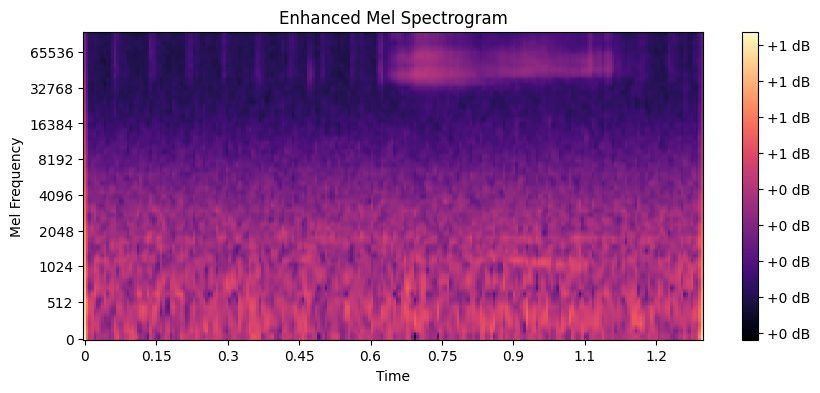

In [ ]:
spect = torch.load(output_dir +"BSM_20170725_13590229_s3.pt")
# plt.figure(figsize=(10, 4))
# plt.imshow(spect, aspect='auto', origin='lower')
res = classify(spect, model, device)
print(res)
# plt.show(block=False)
print(spect.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(spect, sr=sr, hop_length=1024, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Enhanced Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.show()